In [1]:
## import libraries
import os
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers 
from scipy.optimize import curve_fit
import numpy as np
import time
from sklearn.metrics import mean_squared_log_error
import levenberg_marquardt as lm

os.chdir('../')
warnings.filterwarnings('ignore')

In [2]:
tensorflow.__version__

'2.19.0'

In [3]:
demand_training_path = r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\ResearchData\3.TrainingTable.csv'
demand_distribution_path = r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\ResearchData\1.Demand_Distribution.csv'


In [4]:
data = pd.read_csv(demand_training_path)
demand = pd.read_csv(demand_distribution_path)

In [5]:
data.sample(5)

,Delivery_Norm,Shipping_Norm,Damage_rate_Norm,Population_Norm,Employment_Norm,Salary_Norm,Pnum
239,0.339623,0.750000,0.843773,0.266916,0.346928,0.300735,925
145,0.169811,0.625000,0.790206,0.261225,0.485363,0.342743,1767
289,0.440252,0.958333,0.981625,0.104916,0.726587,0.700021,522
168,0.094340,0.500000,0.676909,0.236381,0.253268,0.506158,1540
328,0.358491,0.791667,0.840700,0.110663,0.837999,0.360131,150


In [6]:
demand.sample(5)

,Index,Demand,Latitude,Longitude
157,157,1486,43.652890,122.243444
88,88,2562,38.304477,116.838835
208,208,949,25.045532,101.528069
180,180,1685,34.797239,114.307582
248,248,983,23.656950,116.622604


In [7]:
data


,Delivery_Norm,Shipping_Norm,Damage_rate_Norm,Population_Norm,Employment_Norm,Salary_Norm,Pnum
0,0.006289,0.208333,0.361548,1.000000,0.495541,0.870605,101570
1,0.006289,0.000000,0.856904,0.843071,0.251620,0.966487,71683
2,0.251572,0.625000,0.756064,0.830920,0.137091,0.623857,66496
3,0.000000,0.166667,0.293265,0.811754,0.104655,0.477629,36100
4,0.352201,0.791667,0.890161,0.608333,0.362364,0.932828,33770
...,...,...,...,...,...,...,...
366,0.389937,0.875000,0.896701,0.064510,0.094021,0.154905,3
367,0.937107,1.000000,0.985118,0.174495,0.888984,0.211847,3
368,0.641509,1.000000,0.972424,0.023679,0.075443,0.493849,2
369,1.000000,1.000000,0.932593,0.226672,0.301334,0.288815,1


In [8]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled = scaler.fit_transform(data[['Pnum']])
# scaled = scaler.fit_transform(demand[['Demand']])


In [9]:
list(scaled.reshape(1,-1)[0]) == list(data['Population_Norm'].values)   ## check if the normalized Pnum is equal to the Population_Norm or is it the demand

False

In [10]:
X = data[data.columns[:-1]].values
#y = data['Pnum'].values
y = scaled
#y = demand['Demand'].values


##### SAMPLE SIZE 
TRAIN : 260 \
TEST : 56 \
VAL : 55

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=56, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=55, random_state=123)

In [12]:
print('TRAIN SAMPLES SHAPE :: ', X_train.shape, y_train.shape)
print('TESTING SAMPLES SHAPE :: ', X_test.shape, y_test.shape)
print('VALIDATION SAMPLES SHAPE :: ', X_val.shape, y_val.shape)

TRAIN SAMPLES SHAPE ::  (260, 6) (260, 1)
TESTING SAMPLES SHAPE ::  (56, 6) (56, 1)
VALIDATION SAMPLES SHAPE ::  (55, 6) (55, 1)


Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 22.9779 - mae: 1.6554 - val_loss: 5.6500 - val_mae: 0.8441
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.5812 - mae: 1.9450 - val_loss: 5.5788 - val_mae: 0.8943
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.0210 - mae: 1.9641 - val_loss: 5.5593 - val_mae: 0.9550
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.6785 - mae: 1.8519 - val_loss: 5.5422 - val_mae: 0.9938
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.7419 - mae: 1.9427 - val_loss: 5.4995 - val_mae: 1.0054
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34.0416 - mae: 1.9820 - val_loss: 5.4214 - val_mae: 0.9915
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.6955 - mae: 1.5825 - val_loss: 5.3389 - val_mae: 0.9823
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.1911 - mae: 1.8418 - val_loss: 5.2970 - val_mae: 1.0191
Epoch 9/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.8022 - mae: 1.5

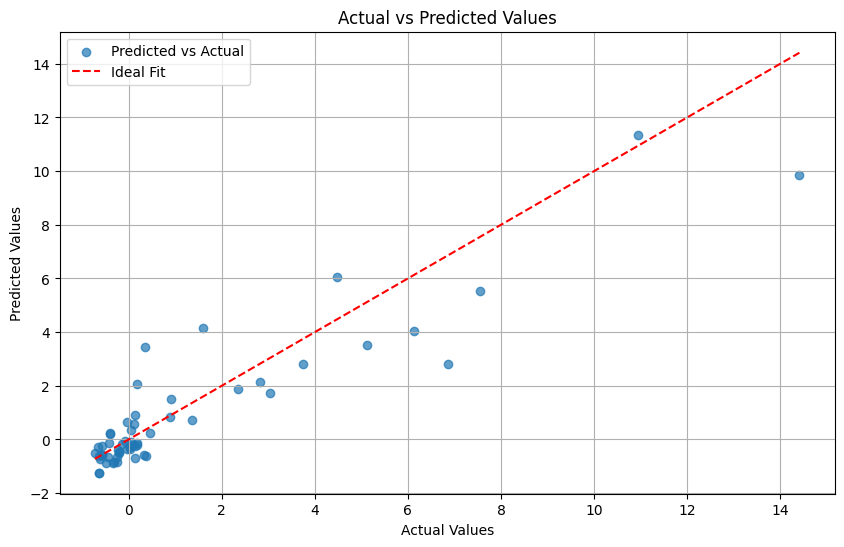

In [13]:
from sklearn.metrics import mean_squared_error

# Ensure the input data is reshaped properly
X_train = np.array(X_train).reshape(X_train.shape[0], -1)
X_val = np.array(X_val).reshape(X_val.shape[0], -1)
X_test = np.array(X_test).reshape(X_test.shape[0], -1)

# Ensure y_train, y_val, and y_test are reshaped properly
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Define the ANN model
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the model
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_ann = model_ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    verbose=1
)

# Predict on the test set
y_test_pred_ann = model_ann.predict(X_test)

# Evaluate the model
test_loss, test_mae = model_ann.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Calculate RMSE
test_rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))
print(f"Test RMSE: {test_rmse_ann}")

import matplotlib.pyplot as plt

# Create analysis DataFrame from predictions and actual values
analysis_df = pd.DataFrame()
analysis_df['test_actual'] = y_test.ravel()
analysis_df['test_pred'] = y_test_pred_ann.ravel()



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['test_actual'], analysis_df['test_pred'], alpha=0.7, label='Predicted vs Actual')
plt.plot([analysis_df['test_actual'].min(), analysis_df['test_actual'].max()],
         [analysis_df['test_actual'].min(), analysis_df['test_actual'].max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save this DataFrame for later use in the pipeline
analysis_df.to_csv('demand_prediction_results1.csv', index=False)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,685 (30.02 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124 (20.02 KB)

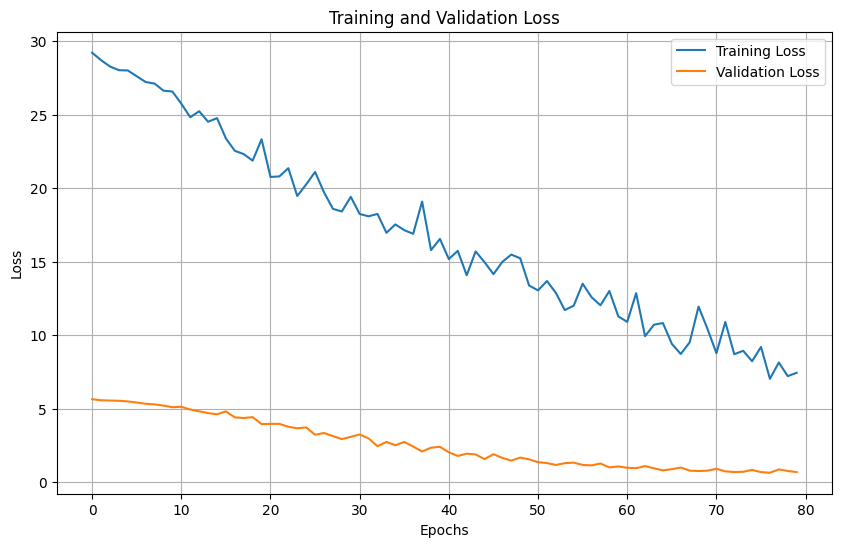

In [15]:
model_ann.summary()

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
#model_ann.save(r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\Models\model_ann.keras')
#print("Model saved successfully!")

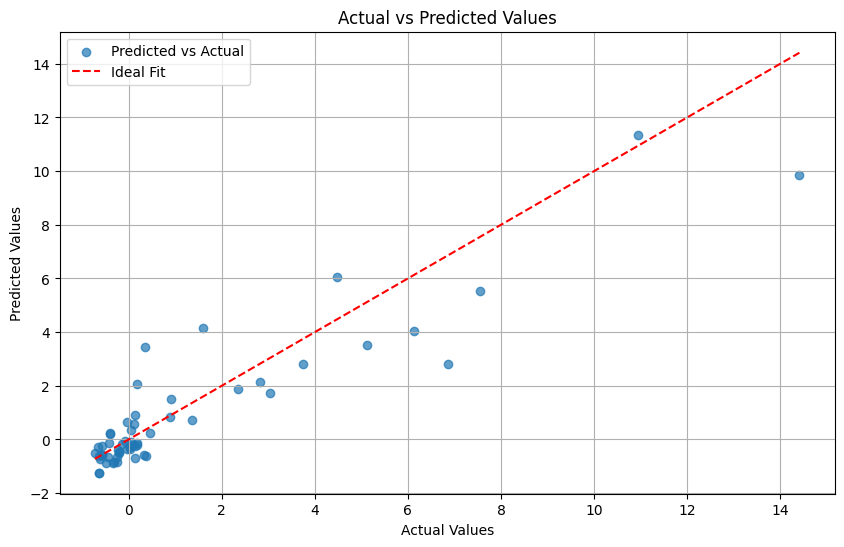

In [16]:
import matplotlib.pyplot as plt

# Create analysis DataFrame from predictions and actual values
analysis_df = pd.DataFrame()
analysis_df['test_actual'] = y_test.ravel()
analysis_df['test_pred'] = y_test_pred_ann.ravel()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['test_actual'], analysis_df['test_pred'], alpha=0.7, label='Predicted vs Actual')
plt.plot([analysis_df['test_actual'].min(), analysis_df['test_actual'].max()],
         [analysis_df['test_actual'].min(), analysis_df['test_actual'].max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model on training data and validate with validation data
xgb_model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

# Predict on the test set
y_test_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.ravel(), y_test_pred))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.8552631099662107


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize the base models
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the base models
rfr.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Get predictions from the base models
rfr_pred = rfr.predict(X_test).reshape(-1, 1)  # Predictions from RandomForestRegressor
svm_pred = svm.predict(X_test).reshape(-1, 1)  # Predictions from SVR

# Stack the predictions as input for the meta-model
stacked_features = np.hstack((rfr_pred, svm_pred))

# Initialize the meta-model (XGBoost)
xgb_meta = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the meta-model on the stacked features
xgb_meta.fit(stacked_features, y_test)

# Predict on the test set using the stacked model
stacked_test_features = np.hstack((rfr.predict(X_test).reshape(-1, 1),
                                   svm.predict(X_test).reshape(-1, 1)))
y_pred = xgb_meta.predict(stacked_test_features)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE) of the stacked model: {rmse}")

Root Mean Squared Error (RMSE) of the stacked model: 0.05890137153097718


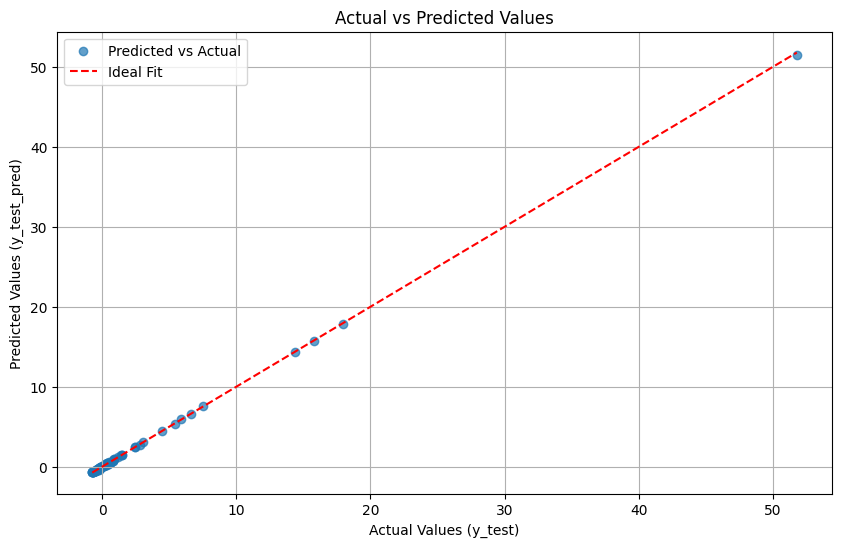

In [19]:
import matplotlib.pyplot as plt

# Plot y_test vs y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_test_pred)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()